In [1]:
import cv2
import numpy as np
import torch
import torchvision
from kan import KAN
import matplotlib.pyplot as plt

In [2]:
plt.style.use('dark_background')
train_data = torchvision.datasets.MNIST(root="./mnist_data", train=True, download=True, transform=None)
test_data = torchvision.datasets.MNIST(root="./mnist_data", train=False, download=True, transform=None)

In [3]:
def preprocess_data(data):
    images = []
    labels = []
    for img, label in data:
        img = np.array(img)
        img = cv2.resize(img, (7, 7))
        img = img.flatten() / 255.0
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = preprocess_data(train_data)
test_images, test_labels = preprocess_data(test_data)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using {device} device")

Using cuda device


In [5]:
dataset = {
    "train_input": torch.from_numpy(train_images).float().to(device),
    "train_label": torch.from_numpy(train_labels).long().to(device),
    "test_input": torch.from_numpy(test_images).float().to("cpu"),
    "test_label": torch.from_numpy(test_labels).long().to("cpu"),
}

In [6]:
def create_kan():
    return KAN(width=[7**2, 10, 10], grid=4, k=3)
model = create_kan()

In [ ]:
def test_acc():
    with torch.no_grad():
        predictions = torch.argmax(model(dataset["test_input"]), dim=1)
        correct = (predictions == dataset["test_label"]).float()
        accuracy = correct.mean()
    return accuracy

def train_acc():
    with torch.no_grad():
        predictions = torch.argmax(model(dataset["train_input"].to('cpu')), dim=1)
        correct = (predictions == dataset["train_label"].to('cpu')).float()
        accuracy = correct.mean()
    return accuracy

# Train the model
results = model.train(
    dataset,
    opt="LBFGS",
    steps=20,
    batch=512,
    loss_fn=torch.nn.CrossEntropyLoss(),
    metrics=(train_acc, test_acc)
)
torch.save(model.state_dict(), "kan.pth")

train loss: 4.71e-01 | test loss: 9.53e-01 | reg: 2.85e+02 :  35%|█  | 7/20 [03:59<06:29, 29.94s/it]

Test accuracy: 78.09%


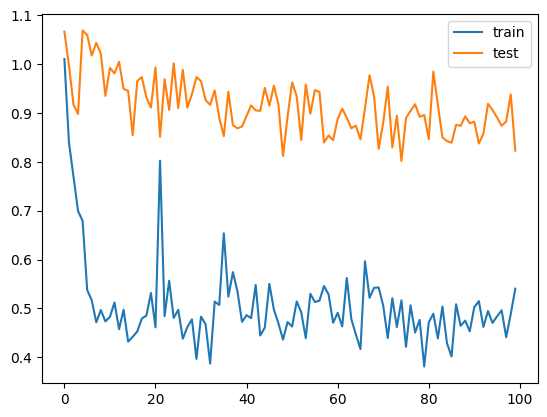

In [159]:
del model
model = create_kan()
model.load_state_dict(torch.load("kan.pth"))

acc = test_acc()
print(f"Test accuracy: {acc.item() * 100:.2f}%")
total_params = sum(p.numel() for p in model.parameters())
print(f"total number of parameters: {total_params}")

plt.plot(results["train_loss"], label="train")
plt.plot(results["test_loss"], label="test")
plt.legend()

## MLP Version

Now let's implement the *FullyConnected* MLP version  

In [144]:
import torch.nn as nn
import torch.optim as optim

class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(7*7, 128)  # 7*7 is the size of the resized and flattened image
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # Output 10 classes for MNIST digits

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [145]:

train_images, train_labels = preprocess_data(train_data)
test_images, test_labels = preprocess_data(test_data)

train_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

In [147]:
def train_and_evaluate(model, train_data, train_labels, test_data, test_labels, epochs=20, batch_size=512):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        for i in range(0, len(train_data), batch_size):
            inputs = train_data[i:i+batch_size]
            labels = train_labels[i:i+batch_size]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        test_acc = evaluate_accuracy(model, test_data, test_labels)
        print(f'Test Accuracy: {test_acc}')
    
def evaluate_accuracy(model, data, labels):
    with torch.no_grad():
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).float()
        accuracy = correct.mean()
    return accuracy

# Create and train the model
fcnn_model = FullyConnectedNN()
print(sum(p.numel() for p in fcnn_model.parameters()))
train_and_evaluate(fcnn_model, train_tensor, train_labels_tensor, test_tensor, test_labels_tensor)

15306
60000
Epoch 1, Loss: 0.8673622012138367
Test Accuracy: 0.7712000012397766
Epoch 2, Loss: 0.668337881565094
Test Accuracy: 0.8240000009536743
Epoch 3, Loss: 0.6007593870162964
Test Accuracy: 0.8389999866485596
Epoch 4, Loss: 0.5518490076065063
Test Accuracy: 0.849399983882904
Epoch 5, Loss: 0.5121419429779053
Test Accuracy: 0.8569999933242798
Epoch 6, Loss: 0.4798769950866699
Test Accuracy: 0.8652999997138977
Epoch 7, Loss: 0.45419207215309143
Test Accuracy: 0.8727999925613403
Epoch 8, Loss: 0.4339473247528076
Test Accuracy: 0.8791000247001648
Epoch 9, Loss: 0.4165957272052765
Test Accuracy: 0.8852999806404114
Epoch 10, Loss: 0.4005856513977051
Test Accuracy: 0.8902000188827515
Epoch 11, Loss: 0.38743308186531067
Test Accuracy: 0.8953999876976013
Epoch 12, Loss: 0.37550297379493713
Test Accuracy: 0.8985000252723694
Epoch 13, Loss: 0.3659308850765228
Test Accuracy: 0.9003999829292297
Epoch 14, Loss: 0.3578766882419586
Test Accuracy: 0.9052000045776367
Epoch 15, Loss: 0.348710387945

In [ ]:
torch.save(fcnn_model.state_dict(), "fcnn_model.pth")
